# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

You are encouraged to create features beyond those available in the feature extraction documentation. Possibilities include the length of the comment/review, its grammar, punctuation, etc.

The Machine Learning task: 
This is a classification task. You will predict **Sentiment**, which is equal to **1 if the movie review is a “good” review** or **0 if it is not a “good” review**. 

Variables that should never be on the X side of the equation: 
- id
- Sentiment
- OR ANY VARIATION OF THESE!


Your work will be assessed on: 
- how accurately your model classifies on a test set
- how well your model generalizes
- the organization and documentation of your Jupyter Notebooks
- communication of your work in class reflections and final presentations
- model improvement over the semester
-  -10 points if you use a random_seed of 74 in your train/test data split

## import libraries we will use:

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

using NLTK, let's explore the data

## Local BinaryClassificationPerformance()

In [2]:
# my_measures
class BinaryClassificationPerformance():
    '''Performance measures to evaluate the fit of a binary classification model, v1.02'''
    
    def __init__(self, predictions, labels, desc, probabilities=None):
        '''Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y'''
        '''probabilities-optional, probability that Y is equal to True'''
        self.probabilities = probabilities
        self.performance_df = pd.concat([pd.DataFrame(predictions), pd.DataFrame(labels).reset_index(drop=True)], axis=1, ignore_index=True)
        self.performance_df.columns = ['preds', 'labls']
        self.desc = desc
        self.performance_measures = {}
        self.image_indices = {}
  
    def compute_measures(self):
        '''Compute performance measures defined by Flach p. 57'''
        self.performance_measures['Pos'] = self.performance_df['labls'].sum()
        self.performance_measures['Neg'] = self.performance_df['labls'].shape[0] - self.performance_df['labls'].sum()
        self.performance_measures['TP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['TN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['Accuracy'] = (self.performance_measures['TP'] + self.performance_measures['TN']) / (self.performance_measures['Pos'] + self.performance_measures['Neg'])
        self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
        self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']
        self.performance_measures['desc'] = self.desc

    def img_indices(self):
        '''Get the indices of true and false positives to be able to locate the corresponding images in a list of image names'''
        self.performance_df['tp_ind'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == True))
        self.performance_df['fp_ind'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == False))
        self.image_indices['TP_indices'] = np.where(self.performance_df['tp_ind']==True)[0].tolist()
        self.image_indices['FP_indices'] = np.where(self.performance_df['fp_ind']==True)[0].tolist()

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [3]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module __main__:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object

In [4]:
movie_data = pd.read_csv('../week04/final_data/moviereviews_train.tsv', sep='\t')

In [5]:
movie_data.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [6]:
movie_data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [7]:
sample_review=movie_data['review'][0]
print(sample_review)

With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally star

## Basic features:

- How long is the text?

In [8]:
sample_review.split()

['With',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with',
 'MJ',
 "i've",
 'started',
 'listening',
 'to',
 'his',
 'music,',
 'watching',
 'the',
 'odd',
 'documentary',
 'here',
 'and',
 'there,',
 'watched',
 'The',
 'Wiz',
 'and',
 'watched',
 'Moonwalker',
 'again.',
 'Maybe',
 'i',
 'just',
 'want',
 'to',
 'get',
 'a',
 'certain',
 'insight',
 'into',
 'this',
 'guy',
 'who',
 'i',
 'thought',
 'was',
 'really',
 'cool',
 'in',
 'the',
 'eighties',
 'just',
 'to',
 'maybe',
 'make',
 'up',
 'my',
 'mind',
 'whether',
 'he',
 'is',
 'guilty',
 'or',
 'innocent.',
 'Moonwalker',
 'is',
 'part',
 'biography,',
 'part',
 'feature',
 'film',
 'which',
 'i',
 'remember',
 'going',
 'to',
 'see',
 'at',
 'the',
 'cinema',
 'when',
 'it',
 'was',
 'originally',
 'released.',
 'Some',
 'of',
 'it',
 'has',
 'subtle',
 'messages',
 'about',
 "MJ's",
 'feeling',
 'towards',
 'the',
 'press',
 'and',
 'also',
 'the',
 'obvious',
 'message',
 'of',
 'drugs',
 

In [9]:
len(sample_review.split())

433

In [10]:
# let's clean it for < br/>
sample_review = sample_review.replace("<br />", " ").replace("\\", "").replace("\'", "'")

In [11]:
sample_review

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.  Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.  The actual feature film bit when it finally starts is only on for 2

In [12]:
movie_data['review'][5]

'I dont know why people think this is such a bad movie. Its got a pretty good plot, some good action, and the change of location for Harry does not hurt either. Sure some of its offensive and gratuitous but this is not the only movie like that. Eastwood is in good form as Dirty Harry, and I liked Pat Hingle in this movie as the small town cop. If you liked DIRTY HARRY, then you should see this one, its a lot better than THE DEAD POOL. 4/5'

In [13]:
'test' in 'this was a test'

True

In [14]:
'boring' in sample_review

True

In [15]:
negative_words=["stupid", "liar", "guilty", "hate", 
                "boring", "bad", "not", "hates", "bad", 
                "terrible", "waste", "hated", "awful", "dumb", "idiot",
               "badly", "mediocore", "ridiculous", "nonsense", "disaster", "monstrously",
               "ill"]
positive_words=["great", "loved", "fun", "cute", "entertaining", "good", "wholesome",
               "nice", "impressive", "funny", "classic", "pretty", "beautiful"]
# count the occurance of any of the posittive words iin the text:

        
        
def getOccurrences(str, word):
    # split the string by spaces in a
    a = str.split(" ")
 
    # search for pattern in a
    count = 0
    for i in range(0, len(a)):
         
        # if match found increase count
        if (word == a[i]):
           count = count + 1
            
    return count 

def word_test(sample_review):
    tot_pos=0
    tot_neg=0
    for word in range(0, len(negative_words)):
        num=getOccurrences(sample_review, negative_words[word])
        if num>0:
            tot_neg+=num
    for word in range(0, len(positive_words)):
        num=getOccurrences(sample_review, positive_words[word])
        if num>0:
            tot_pos+=num
    if (tot_pos+tot_neg)==0:
        return 1.0
    else:
#     print(tot_pos, tot_neg)
        return((tot_pos-tot_neg) / (tot_pos+tot_neg))

word_test(sample_review)

-0.42857142857142855

In [16]:
l=movie_data['review'].str.split(' ').str.len()
type(l)

pandas.core.series.Series

In [17]:
# list of strings
lst = []
# Calling DataFrame constructor on list
# df = pd.DataFrame(lst)
# df
for i in range(0, len(movie_data['review'])): 
    n= word_test(movie_data['review'][i])
    lst.append(n+1)
    
#     print("movie_data['sent_count']",n)
df = pd.DataFrame(lst)
df  
# word_test(movie_data['review'])

,0
0,0.571429
1,1.600000
2,0.000000
3,0.000000
4,1.000000
...,...
24995,2.000000
24996,1.500000
24997,1.000000
24998,0.000000


# Function for feature building and extraction on natural language data

In [18]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    
    #FEATURES:
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
#     movie_data['punc_count'] = movie_data['review'].str.count("\.")
#     movie_data['sent_count']=[]
    lst = []
    # Calling DataFrame constructor on list
    # df = pd.DataFrame(lst)
    # df
    for i in range(0, len(movie_data['review'])): 
        n= word_test(movie_data['review'][i])
        lst.append(n+1)
    #     print("movie_data['sent_count']",n)
    movie_data['sent_count']= pd.DataFrame(lst)
#     pd.DataFrame(dict(foo=range(10)))
#     df 

#     X_quant_features = movie_data[["word_count", "punc_count",  'sent_count']]
    X_quant_features = movie_data[["word_count", 'sent_count']]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

In [19]:
movie_data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [20]:
lst = []
    # Calling DataFrame constructor on list
    # df = pd.DataFrame(lst)
    # df
for i in range(0, len(movie_data['review'])): 
    n= word_test(movie_data['review'][i])
    lst.append(n+1)
    #     print("movie_data['sent_count']",n)
    movie_data['sent_count']= pd.DataFrame(lst)
movie_data['sent_count']  

# 0 negative - 1 neutral - 2 positive 

0        0.571429
1        1.600000
2        0.000000
3        0.000000
4        1.000000
           ...   
24995    2.000000
24996    1.500000
24997    1.000000
24998    0.000000
24999    2.000000
Name: sent_count, Length: 25000, dtype: float64

In [21]:
#how many good sentiments you agree w/?
help(movie_data)

Help on DataFrame in module pandas.core.frame object:

class DataFrame(pandas.core.generic.NDFrame)
 |  DataFrame(data=None, index: Union[Collection, NoneType] = None, columns: Union[Collection, NoneType] = None, dtype: Union[str, numpy.dtype, ForwardRef('ExtensionDtype'), NoneType] = None, copy: bool = False)
 |  
 |  Two-dimensional, size-mutable, potentially heterogeneous tabular data.
 |  
 |  Data structure also contains labeled axes (rows and columns).
 |  Arithmetic operations align on both row and column labels. Can be
 |  thought of as a dict-like container for Series objects. The primary
 |  pandas data structure.
 |  
 |  Parameters
 |  ----------
 |  data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
 |      Dict can contain Series, arrays, constants, or list-like objects.
 |  
 |      .. versionchanged:: 0.23.0
 |         If data is a dict, column order follows insertion-order for
 |         Python 3.6 and later.
 |  
 |      .. versionchanged:: 0.25.

In [22]:
movie_data['sentiment'].where(movie_data['sent_count'] > 1).describe()

count    11043.000000
mean         0.646020
std          0.478225
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: sentiment, dtype: float64

In [23]:
movie_data['sentiment'].where(movie_data['sent_count'] > 1).value_counts()

1.0    7134
0.0    3909
Name: sentiment, dtype: int64

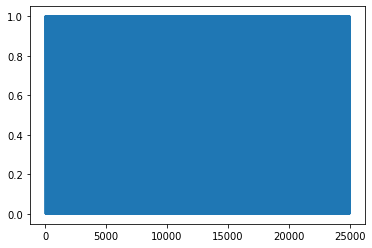

In [24]:
plt.plot(movie_data['sentiment'])

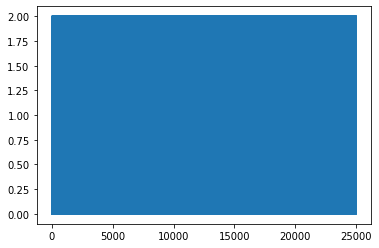

In [25]:
plt.plot(movie_data['sent_count'] )

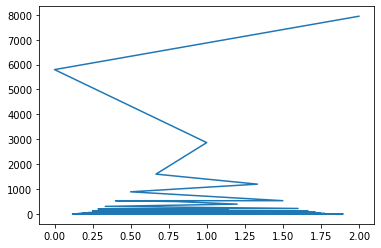

In [26]:
plt.plot(movie_data['sent_count'].value_counts())

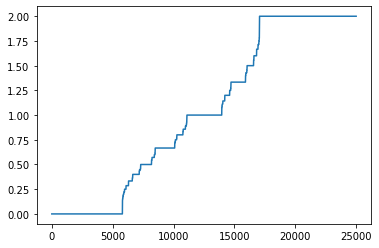

In [27]:
plt.plot(sorted(movie_data['sent_count']))

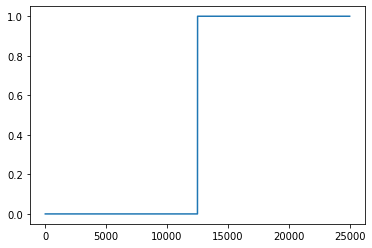

In [28]:
plt.plot(sorted(movie_data['sentiment']))

In [29]:
df= movie_data.sort_values('sent_count', ignore_index=True)

In [30]:
# df=df.reset_index()

In [31]:
df.head()

,id,sentiment,review,sent_count
0,5425_10,1,This- and not a certain slightly overrated Sou...,0.0
1,6800_1,0,I signed in just to comment on how awfully stu...,0.0
2,6288_3,0,"Having read many of the comments here, I'm sur...",0.0
3,2608_10,1,The final season of Roseanne was a roller coas...,0.0
4,4803_8,1,It's hard to find an outright bad historical d...,0.0


In [32]:
df.sent_count

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
24995    2.0
24996    2.0
24997    2.0
24998    2.0
24999    2.0
Name: sent_count, Length: 25000, dtype: float64

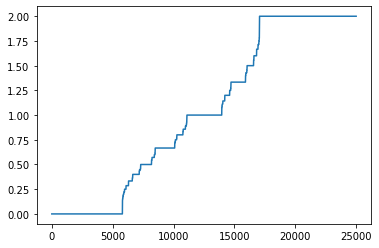

In [33]:
plt.plot(df.sent_count)

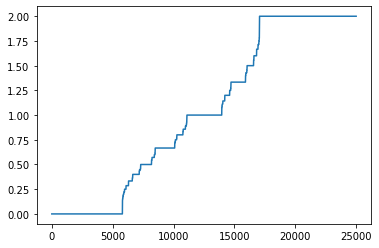

In [34]:
plt.plot(df.sent_count)

<AxesSubplot:xlabel='sent_count', ylabel='sentiment'>

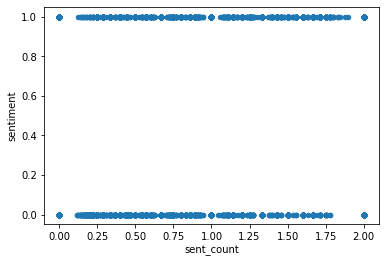

In [35]:
df.plot('sent_count','sentiment', kind='scatter')

array([<AxesSubplot:xlabel='sent_count'>], dtype=object)

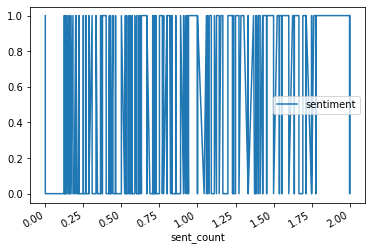

In [36]:
df.plot('sent_count', subplots=True)

<AxesSubplot:>

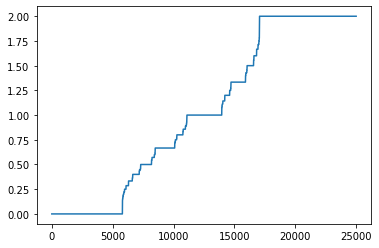

In [37]:
df.sent_count.plot()

In [38]:
#scipy iimprot intergrate 

# Create training and test sets from function

In [39]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../week04/final_data/moviereviews_train.tsv', my_random_seed=14)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  sent_count
0         433    0.571429
1         158    1.600000
2         378    0.000000
3         379    0.000000
4         367    1.000000


In [40]:
print(X_train)

  (0, 3989)	8.335647697032506
  (0, 4412)	1.7754138699959905
  (0, 4793)	27.133007006149967
  (0, 5983)	5.564819217543911
  (0, 8412)	70.57782809110465
  (0, 8564)	0.991129732661582
  (0, 11008)	18.64692897925703
  (0, 13677)	0.49229386382049717
  (0, 15498)	3.124746102864991
  (0, 18429)	12.816591443220764
  (0, 19772)	4.500408401221109
  (0, 21858)	79.42098927174258
  (0, 22965)	2.5366961122953584
  (0, 23389)	10.921524171688507
  (0, 23579)	1.5037935198432184
  (0, 24734)	0.7708982127649663
  (0, 25819)	2.329504392249618
  (0, 28066)	11.611616715210138
  (0, 29397)	28.384529712941433
  (0, 31925)	1.9137108155118951
  (0, 32448)	2.848667634749281
  (0, 35080)	23.085363894922864
  (0, 36102)	61.86049398398591
  (0, 37777)	0.5794082972690775
  (0, 38500)	58.66558642393408
  :	:
  (19999, 88541)	1.1888595427583029
  (19999, 92716)	2.5549604538516024
  (19999, 94464)	27.04969265408981
  (19999, 97469)	1.9499346942946802
  (19999, 99120)	2.7627839481270864
  (19999, 100105)	10.82740952520

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [41]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 10051, 'Neg': 9949, 'TP': 4526, 'TN': 5394, 'FP': 4555, 'FN': 5525, 'Accuracy': 0.496, 'Precision': 0.49840325955291265, 'Recall': 0.45030345239279673, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [42]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10051, 'Neg': 9949, 'TP': 10051, 'TN': 9949, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [43]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10051, 'Neg': 9949, 'TP': 10051, 'TN': 9949, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [44]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10051, 'Neg': 9949, 'TP': 9635, 'TN': 9804, 'FP': 145, 'FN': 416, 'Accuracy': 0.97195, 'Precision': 0.9851738241308794, 'Recall': 0.9586110834742811, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [45]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10051, 'Neg': 9949, 'TP': 10051, 'TN': 9949, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [46]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10051, 'Neg': 9949, 'TP': 10051, 'TN': 9949, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [47]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10051, 'Neg': 9949, 'TP': 9047, 'TN': 5956, 'FP': 3993, 'FN': 1004, 'Accuracy': 0.75015, 'Precision': 0.6937883435582822, 'Recall': 0.9001094418465825, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

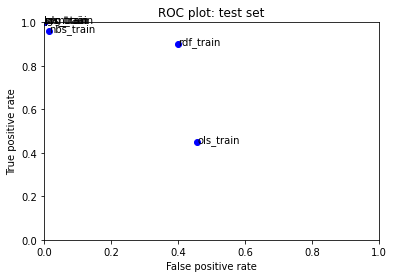

In [48]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [49]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [50]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
2
This movie is bizarre. Better put, it's \freakin' weird\". I could give you a plot summary, or some hoity toity analysis, but I would consider it a waste of your time. All anybody needs to know about this movie is two young sisters, one incestuous relationship, homicide, post mortem mutilation, and one really disturbing infatuation. At the end of the movie you feel like you need to go take a shower to wash the filth off yourself, but not in a good way like after \"Pulp Fiction\" or \"Fight Club\". It's like you're a teenager (or high schooler being that i am myself still a teenager)and have just done something you A: wish you hadn't done, and B: hope to the Good Lord of Heaven and Earth that your parents never find out about. And nobody likes that. My advise is that rather than defiling your mind and by watching piece of wanton cinematic filth, just go waste your time on something a little less horrible and watch \"Kazaam\"(yes, I would rather watch \"Kaz

3872
This was a rip-off of the same garbage we had to watch Bob Saget host during the half-hour before this. Dave Coulier only thought he was funny and it was pretty much the same show as America's Funniest Home Videos except with a hosts who have a combined IQ of three. Tawny Kitaen must've really needed the money and Coulier had to go to the recycle bin for his jokes. It was torture enough having to see him imitate Popeye and other washed up cartoon starts on Full House. That one dude who played all of the practical jokes on everyone deserves to be on the receiving end of a Grade A wedgie. Coulier must've needed to money to please Alannis Morisette while they were dating.
* * * * * * * * * 
4016
They're showing this on some off-network. It's well crap. While it is not as bad as the B-movies they show on the Sci-fi network on Saturdays but still a fairly large pile of crap. The acting is passable. The plot and writing are fairly sub-standard and the pacing is entirely too slow. Every 

6362
I sat down to watch this movie with my friends with very low expectations. My expectations were no where near low enough. I honestly could not tell what genre this movie was from watching it, and if it was a comedy, the humor was completely missed. The plot was nonexistent and the acting was horrendous. My friends and I managed to watch approximately 30 to 40 minutes of this film before we turned it off and promptly begged the video store to take it back. I do NOT recommend this movie to anyone unless you are purposely trying to watch the worst movies of all time. I honestly don't know how this film lasted more than a day in theatres and moreover I can not understand why anyone would willing watch it, considering not only it's very uninteresting title but also the lack of any famous actors/actresses in it's cast. This review is not a joke and I honestly think this could possibly be the worst movie ever made. It's certainly the worst movie I've ever had to sit through.
* * * * * * 

9360
Wow. Simply awful. I was a fan of the original movie, and begrudgingly sat through part 2, 3 was and improvement. 4,5 and Freddy's Dead were pretty bad. But NOTHING is as bad as Freddy's Nightmares. Freddy acts as a Rod Serlingesq host of this anthology series.<br /><br />I can accept how Freddy became one punchline after another, but at least in the movies the appeal of Freddy carried the movies, but here these were so poorly made, they looked like high school productions of a horror series. The poor actors, if you really want to call yourself that after doing this show were obviously exactly what they paid for. I'm nearly certain this was a stopping point for two types of actors. Ones just starting on the Hollywood ladder, brand new willing to take any part that would put off their having to take that porn job they were offered last week, or seasoned actors on their way down the Hollywood ladder willing to take any part that would put off their having to take that porn job they 

12407
Plot Synopsis: When his wife, a news reporter, is kidnapped & replaced with an android double, Secret Service agent Eric Phillips tracks her down & uncovers a plan by an arms dealer to create an army of invincible androids to assassinate world leaders.<br /><br />I wasn't expecting much when I first saw this sequel to Richard Pepin's low-budget sci-fi / action hybrid \Cyber Tracker\". That film was nothing special, not to mention a blatant rip-off of both \"The Terminator\" & \"RoboCop\". This sequel is the same as before, with an all-out action sequence opening the film. There are plenty of explosions, heavy gunfire & a huge bodycount, as well as some martial-arts moves courtesy of the film's star, Don \"The Dragon\" Wilson. The whole film seems like a series of action scenes strung together with minimal plot. On the acting front, Wilson is a bad actor. He really needs a personality transplant."
* * * * * * * * * 
12466
I can't believe it, IMDb really does have every TV show kno

13102
an very good storyline, good thrill to it ... but the 10 last seconds destroyed the whole movie... what happened? extremely well made and an good story destroyed in the last seconds... sorry to say but a 1 in vote... thats what it it deserve, i would think that Chris Shadley could come up with a better end... but maybe next time : ) all this meaningless blood gore for nothing? the end would lift the story to close to a 10, but it didn't.... the end destroyed the whole story, i think most people aren't lame and when they goes a movie thy want a good end, even if it is intricate ... but the only lame here is the end... sorry
* * * * * * * * * 
13106
I'm Irish and I've been living in Denmark for a while so I was looking forward to going home last week so I could see Intermission. And I will go on record as saying:<br /><br />THIS FILM IS AWFUL.<br /><br />It is not quite as bad a something like \The Most Fertile Man in Ireland\" but it definitely does not stand up there with other I

15045
I guess this movie is a fitting tribute to the first Superman film,as it is just as crummy and painfully long as the original.<br /><br />After an opening scene consisting solely of murky intergalactic visuals, the credits pay homage to the even-crummy-looking-for-their-time futuristic sweeping credits of the original Superman film.<br /><br />Then there is some more murky stuff. Ma Kent sees some kind of murky ruckus on the farm, and spends a good portion of my life slowly walking up to some debris in the cornfield. Then Superman sneaks up on her and faints.<br /><br />Next we catch up with Lex Luthor in a scene about many murky close-ups of an old lady as she dies. We don't see Luthor's face until the end of the scene, an early instance of the film's drive to leave no hackneyed stone unturned. Lex Luthor is a guy who doesn't like Superman because he is not human. Also, he probably doesn't like humans either, as the movie occasionally features some kind of plot about Lex Luthor 

16049
There are so many goofy things about this movie that I can't possibly name but a few:<br /><br />BOGART's character: 1. His name  Whip McCord (too easy, so I'll leave it at that. Boy, it makes `Humphrey' sound good.) 2. His long, curly hair and silly sideburns. 3. His Black Bart get-up, complete with spurs! 4. Not sure what shade of lipgloss they've got him wearing, but it ain't none too flattering.<br /><br />CAGNEY's character (Jim Kincaid ): 1. His lipstick doesn't do him any favors, either. 2. The man is being swallowed by his hat during the entire film! Could they not find a hat to fit him? Even a LITTLE?!!?! 3. His pants are too tight in the rear. 4. He blows the smoke off his gun one too many times, if you know what I mean, and I think you do.<br /><br />If you are a casual Bogart or Cagney fan, and figure it might be a change of pace to see them in a western, do yourself a favor and forget that thought. EVEN THE HORSES LOOK EMBARRASSED! (That is, when they don't look bor

17840
The actors did a really good job playing their roles--particularly the mom. However, as the movie progressed I found I was watching it more for their acting and not because I cared in the least for the people. And, at times, I felt irritated by the irresponsible and hands-off approach to parenting displayed again and again. The daughter is a 17 year-old shallow skank whose main ambition in life is bedding famous men and becoming a dancing nyphette (complete with lots of \booty shaking\"). The son is a guy with low self-esteem that seems very desperate for a relationship and friends--so much that he throws a drug party late in the film. The husband and wife are both bored, but rather than put energy into their stale relationship would rather seek out new partners (though the wife picks poorly, as the man she \"throws herself at\" happens to be gay---OOPS!). I just felt that ALL the characters needed to grow up and had a hard time caring for such shallow jerks. I think the author's

18673
Don't let the title trick you into watching this movie. I read the title, saw that it came on in the middle of the night, and figured it was one of those soft porn movies. This movie is bad. If you like soft porn movies, then I'm sorry to say this isn't one. There are a lot of sex but nothing shown and they only last for 5 seconds or so.
* * * * * * * * * 
18676
I saw this movie at an actual movie theater (probably the $2.00 one) with my cousin and uncle. We were around 11 and 12, I guess, and really into scary movies. I remember being so excited to see it because my cool uncle let us pick the movie (and we probably never got to do that again!) and sooo disappointed afterwards!! Just boring and not scary. The only redeeming thing I can remember was Corky Pigeon from Silver Spoons, and that wasn't all that great, just someone I recognized. I've seen bad movies before and this one has always stuck out in my mind as the worst. This was from what I can recall, one of the most boring,

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [51]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2449, 'Neg': 2551, 'TP': 1029, 'TN': 1454, 'FP': 1097, 'FN': 1420, 'Accuracy': 0.4966, 'Precision': 0.48400752587017876, 'Recall': 0.42017149857084524, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [52]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2449, 'Neg': 2551, 'TP': 2065, 'TN': 2106, 'FP': 445, 'FN': 384, 'Accuracy': 0.8342, 'Precision': 0.8227091633466136, 'Recall': 0.8432013066557779, 'desc': 'svm_test'}


### MODEL: logistic regression

In [53]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2449, 'Neg': 2551, 'TP': 2082, 'TN': 2072, 'FP': 479, 'FN': 367, 'Accuracy': 0.8308, 'Precision': 0.8129636860601328, 'Recall': 0.8501429154757044, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [54]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2449, 'Neg': 2551, 'TP': 1814, 'TN': 1879, 'FP': 672, 'FN': 635, 'Accuracy': 0.7386, 'Precision': 0.7296862429605793, 'Recall': 0.740710494079216, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [55]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2449, 'Neg': 2551, 'TP': 2062, 'TN': 2123, 'FP': 428, 'FN': 387, 'Accuracy': 0.837, 'Precision': 0.8281124497991967, 'Recall': 0.8419763168640262, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [56]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2449, 'Neg': 2551, 'TP': 2032, 'TN': 2054, 'FP': 497, 'FN': 417, 'Accuracy': 0.8172, 'Precision': 0.8034796362198497, 'Recall': 0.8297264189465088, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [57]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2449, 'Neg': 2551, 'TP': 2190, 'TN': 1535, 'FP': 1016, 'FN': 259, 'Accuracy': 0.745, 'Precision': 0.6830941983780412, 'Recall': 0.8942425479787668, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

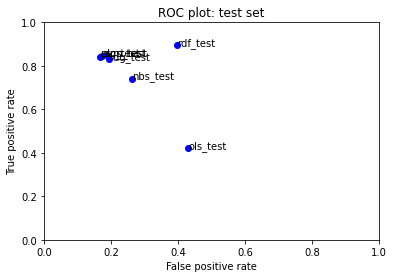

In [58]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [59]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../week04/final_data/moviereviews_test.tsv', my_random_seed=14, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  sent_count
0         131    0.000000
1         169    0.500000
2         176    1.500000
3         112    2.000000
4         133    1.333333
5         331    0.000000
6         121    1.333333
7         230    2.000000
8          59    0.000000
9         224    2.000000
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [60]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.44192


In [61]:
raw_data.head()

,id,review,word_count,sent_count
0,12311_10,Naturally in a film who's main themes are of m...,131,0.000000
1,8348_2,This movie is a disaster within a disaster fil...,169,0.500000
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,1.500000
3,7186_2,Afraid of the Dark left me with the impression...,112,2.000000
4,12128_7,A very accurate depiction of small time mob li...,133,1.333333


In [62]:
my_submission.head()

,id,prediction
0,12311_10,0
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1


In [63]:
my_submission.shape

(25000, 2)

In [65]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('my_moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation